<div style="margin-bottom: 48px;">
<a href="Bank_Personal_Loan_Modelling.csv" download style="background-color:#007BFF; color:#fff; padding:10px 15px; text-decoration:none; border-radius:5px; margin-right:20px; display:inline-block;">
  📥 Download Data CSV
</a>

<a href="PyTorch.yml" download style="background-color:#007BFF; color:#fff; padding:10px 15px; text-decoration:none; border-radius:5px; margin-right:20px; display:inline-block;">
  📥 Download Python yml
</a>
</div>


# Context

This case is about a bank which has a growing customer base. 

Majority of these customers are liability customers (depositors) with varying size of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors). A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns to better target marketing to increase the success ratio with a minimal budget.

The department wants to build a model that will help them identify the potential customers who have a higher probability of purchasing the loan. This will increase the success ratio while at the same time reduce the cost of the campaign. 

|Variable | Description|
|--|--|
|ID | Customer ID |
|Age |	Customer's age in completed years |
|Experience|	#years of professional experience |
|Income|	Annual income of the customer ($000)|
|ZIPCode|	Home Address ZIP code.|
|Family|	Family size of the customer|
|CCAvg|	Avg. spending on credit cards per month ($000)|
|Education|	Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional|
|Mortgage|	Value of house mortgage if any. ($000)|
|Personal Loan|	Did this customer accept the personal loan offered in the last campaign?|
|Securities Account|	Does the customer have a securities account with the bank?|
|CD Account|	Does the customer have a certificate of deposit (CD) account with the bank?|
|Online|	Does the customer use internet banking facilities?|
|CreditCard|	Does the customer use a credit card issued by UniversalBank?|


# Analysis

In [ ]:
import sklearn
import xgboost
import catboost
import torch

import pandas as pd
import duckdb as db
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import plotly
import plotly.express as px
import plotly.io as pio
from IPython.display import Image, display

In [2]:
# Data processing
cols_categorical = {'id', 'zip code','education','personal loan', 'securities account', 'cd account', 'online', 'creditcard'}

cols = pd.read_csv('Bank_Personal_Loan_Modelling.csv', nrows=0).columns
dtypes_mapping = {col: 'category' if col.lower() in cols_categorical else 'float32' for col in cols}

loans = pd.read_csv('Bank_Personal_Loan_Modelling.csv', dtype = dtypes_mapping)

In [3]:
# Quick exploratory analysis
def quick_column_summary(df):
    summary = pd.DataFrame({
        'dtype': df.dtypes,
        'n_unique': df.nunique(dropna=True),
        'missing': df.isna().sum(),
        'missing_pct': df.isna().mean() * 100,
        'mode': df.mode(dropna=True).iloc[0]
    })
    return summary

def quick_column_summary(df):
    summary = pd.DataFrame({
        'dtype': df.dtypes,
        'n_unique': df.nunique(dropna=True),
        'missing': df.isna().sum(),
        'missing_pct': df.isna().mean() * 100,
    })

    # Compute mode safely
    summary['mode'] = df.apply(lambda col: col.mode(dropna=True).iloc[0] if not col.mode(dropna=True).empty else np.nan)

    # Add min, median, max (only for numeric columns)
    summary['min'] = df.apply(lambda col: col.min(skipna=True) if pd.api.types.is_numeric_dtype(col) else np.nan)
    summary['median'] = df.apply(lambda col: col.median(skipna=True) if pd.api.types.is_numeric_dtype(col) else np.nan)
    summary['max'] = df.apply(lambda col: col.max(skipna=True) if pd.api.types.is_numeric_dtype(col) else np.nan)

    # First 3 unique values as string
    summary['sample_unique'] = df.apply(lambda col: ', '.join(map(str, col.dropna().unique()[:3])))

    return summary

print("Data EDA Summary")
quick_column_summary(loans)

Data EDA Summary


,dtype,n_unique,missing,missing_pct,mode,min,median,max,sample_unique
ID,category,5000,0,0.0,1,NaN,NaN,NaN,"1, 2, 3"
Age,float32,45,0,0.0,35.0,23.0,45.0,67.0,"25.0, 45.0, 39.0"
Experience,float32,47,0,0.0,32.0,-3.0,20.0,43.0,"1.0, 19.0, 15.0"
Income,float32,162,0,0.0,44.0,8.0,64.0,224.0,"49.0, 34.0, 11.0"
ZIP Code,category,467,0,0.0,94720,NaN,NaN,NaN,"91107, 90089, 94720"
Family,float32,4,0,0.0,1.0,1.0,2.0,4.0,"4.0, 3.0, 1.0"
CCAvg,float32,108,0,0.0,0.3,0.0,1.5,10.0,"1.6, 1.5, 1.0"
Education,category,3,0,0.0,1,NaN,NaN,NaN,"1, 2, 3"
Mortgage,float32,347,0,0.0,0.0,0.0,0.0,635.0,"0.0, 155.0, 104.0"
Personal Loan,category,2,0,0.0,0,NaN,NaN,NaN,"0, 1"


Note that a mortgage-having individual has a 'Mortgage' variable greater than zero. There is no distinction with this variable between someone owning a home outright, renting, etc.

In [4]:
# Number of CPU Cores / Only using CPU
nCores = 16

# Randomizer Seed
RANDOM_STATE = 2030

# Test-Train splitting data
target = 'Personal Loan'

X = loans.drop(columns=[target])
y = loans[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state = RANDOM_STATE)

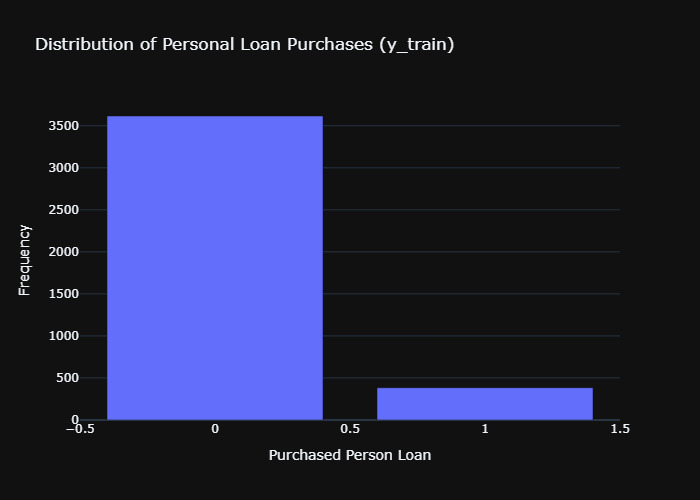

In [16]:
# Convert Series to DataFrame
df_plot = y_train.value_counts().reset_index()
df_plot.columns = ['Purchased Person Loan', 'Frequency']

# Plotting training target variable
fig = px.bar(
    data_frame = df_plot,
    x = 'Purchased Person Loan',
    y = 'Frequency',
    title = 'Distribution of Personal Loan Purchases (y_train)',
    template = 'plotly_dark'
)

fig.write_image('fig1.png')
display(Image(filename="fig1.png"))

In [6]:
# Identify columns for preprocessing
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols   = X.select_dtypes(include=[np.number]).columns.tolist()

# Preprocessor definition
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [8]:
# Define models and their parameter grids for gridsearch cv
model_configs = {

    'logistic': {
        'model': LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=RANDOM_STATE),
        'params': {'model__C': [0.01, 0.1, 1, 10]}
    },

    'svc': {
        'model': LinearSVC(penalty='l1', dual=False, max_iter=5000, random_state=RANDOM_STATE),
        'params': {'model__C': [0.01, 0.1, 1, 10]}
    },

    'xgboost': {
        'model': XGBClassifier(eval_metric='logloss', tree_method='hist',  random_state=RANDOM_STATE),
        'params': {
            'model__n_estimators': [100, 300],
            'model__max_depth': [4, 6],
            'model__learning_rate': [0.01, 0.1]
        }
    },

    'catboost': {
        'model': CatBoostClassifier(verbose=0, task_type='GPU',  random_state=RANDOM_STATE),
        'params': {
            'model__iterations': [100, 300],
            'model__depth': [4, 6],
            'model__learning_rate': [0.01, 0.1]
        }
    },

    'dummy_always_zero': {
        'model': DummyClassifier(strategy='constant', constant=0),
        'params': {}
    },

    'dummy_always_one': {
        'model': DummyClassifier(strategy='constant', constant=1),
        'params': {}
    },

    'dummy_stratified': {
        'model': DummyClassifier(strategy='stratified',  random_state=RANDOM_STATE),
        'params': {}
    },

    'dummy_uniform': {
        'model': DummyClassifier(strategy='uniform',  random_state=RANDOM_STATE),
        'params': {}
    },

    'dummy_prior': {
        'model': DummyClassifier(strategy='prior',  random_state=RANDOM_STATE),
        'params': {}
    }
    
}

In [ ]:
# Implements 10-fold CV to choose best hyper parameters for each model, then uses the best parameter set for each model to predict the test set
results = []

for name, config in model_configs.items():
    print(f"\nTraining {name}...")

    if name == 'catboost':
        
        # Compute categorical column indices for CatBoost
        cat_features_indices = [X.columns.get_loc(col) for col in categorical_cols]

        # Reinitialize CatBoost with cat_features in constructor
        model = CatBoostClassifier(verbose=0, task_type='GPU',  random_state=RANDOM_STATE, cat_features=cat_features_indices)

        # Skip encoding: passthrough raw data
        pipe = Pipeline([
            ('preprocess', 'passthrough'),
            ('model', model)
        ])

        param_grid = config['params']

        # Use raw X data, not transformed
        X_train_model = X_train.copy()
        X_test_model = X_test.copy()

    else:

        pipe = Pipeline([
            ('preprocess', preprocessor),
            ('model', config['model'])
        ])

        param_grid = config['params']
        X_train_model = X_train.copy()
        X_test_model = X_test.copy()

    # Grid Search
    grid = GridSearchCV(pipe, param_grid, cv=10, scoring='f1', n_jobs=nCores, verbose=1)
    grid.fit(X_train_model, y_train)

    best_model = grid.best_estimator_

    # Predict
    y_pred = best_model.predict(X_test_model)

    # Compute test score
    score = f1_score(y_test, y_pred)
    
    # Compute confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    results.append({
        'model': name,
        'best_score (f1)': grid.best_score_,
        'test_score (f1)': score,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred),
        'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0.0,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'best_params': grid.best_params_
    })


Training logistic...
Fitting 10 folds for each of 4 candidates, totalling 40 fits

Training svc...
Fitting 10 folds for each of 4 candidates, totalling 40 fits

Training xgboost...
Fitting 10 folds for each of 8 candidates, totalling 80 fits

Training catboost...
Fitting 10 folds for each of 8 candidates, totalling 80 fits

Training dummy_always_zero...
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Training dummy_always_one...
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Training dummy_stratified...
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Training dummy_uniform...
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Training dummy_prior...
Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [10]:
# Display results
results_df = pd.DataFrame(results).sort_values(by='best_score (f1)', ascending=False)
print(results_df)

               model  best_score (f1)  test_score (f1)  Accuracy  Precision  \
3           catboost         0.931500         0.917127     0.985   0.976471   
2            xgboost         0.929276         0.923077     0.986   0.976744   
0           logistic         0.739183         0.785276     0.965   0.955224   
1                svc         0.736628         0.777778     0.964   0.954545   
5   dummy_always_one         0.175180         0.175182     0.096   0.096000   
7      dummy_uniform         0.159547         0.161074     0.500   0.096000   
6   dummy_stratified         0.083117         0.133333     0.831   0.131313   
4  dummy_always_zero         0.000000         0.000000     0.904   0.000000   
8        dummy_prior         0.000000         0.000000     0.904   0.000000   

     Recall  Specificity  TP   TN   FP  FN  \
3  0.864583     0.997788  83  902    2  13   
2  0.875000     0.997788  84  902    2  12   
0  0.666667     0.996681  64  901    3  32   
1  0.656250     0.996681 

Focusing on f1-score:

We saw CATBOOST perform the best when training, but XGBOOST actually performed the best on the test data. The difference between their performance is due to CATBOOST making two additional false-negative predictions compared to XGBOOST.